# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

practice_dir_path = '/content/drive/MyDrive/01 Basics/'
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [3]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [4]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.5 MB/s eta 0:00:00


In [5]:

import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
#from modules.classification import TimeSeriesKNN, calculate_accuracy
#from modules.image_converter import image2ts
from modules.utils import read_ts, z_normalize, sliding_window, random_walk
from modules.plots import plot_ts


## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [6]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [7]:
def ED_distance(ts1: np.ndarray, ts2: np.ndarray) -> float:
    """
    Calculate the Euclidean distance between two time series.

    Parameters
    ----------
    ts1: the first time series
    ts2: the second time series

    Returns
    -------
    ed_dist: euclidean distance between ts1 and ts2
    """
    if len(ts1) != len(ts2):
        raise ValueError("Time series must have the same length")

    # Вычисление евклидова расстояния
    ed_dist = np.sqrt(np.sum((ts1 - ts2) ** 2))
    return ed_dist

def random_walk(n: int) -> np.ndarray:
    """
    Generate the time series based on Random Walk model.

    Parameters
    ----------
    n: length of time series

    Returns
    -------
    random_walk_ts: generated time series
    """
    value = 0
    random_walk_ts = [value]
    directions = ["UP", "DOWN"]

    for i in range(1, n):
        step = random.choice(directions)
        if step == "UP":
            value += 1
        else:
            value -= 1
        random_walk_ts.append(value)

    return np.array(random_walk_ts)

def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly.

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """
    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [8]:
import numpy as np
from sktime.distances import euclidean_distance

# Длина временных рядов
n = 100

# Генерация двух временных рядов
ts1 = random_walk(n)
ts2 = random_walk(n)

# Вычисление евклидова расстояния с использованием обеих функций
my_distance = ED_distance(ts1, ts2)
sklearn_distance = euclidean_distance(ts1, ts2)

# Проверка равенства значений
test_distances(sklearn_distance, my_distance)

print(f"My Distance: {my_distance}")
print(f"Sktime Distance: {sklearn_distance}")

My Distance: 76.31513611335565
Sktime Distance: 76.31513611335565


### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [9]:
import numpy as np

def DTW_distance(ts1: np.ndarray, ts2: np.ndarray) -> float:
    """
    Вычисление DTW расстояния между двумя временными рядами одинаковой длины.

    Параметры
    ----------
    ts1: np.ndarray
        Первый временной ряд.
    ts2: np.ndarray
        Второй временной ряд.

    Возвращает
    -------
    float
        DTW расстояние между ts1 и ts2.
    """

    n = len(ts1)

    # Инициализация матрицы DTW
    dtw = np.full((n + 1, n + 1), np.inf)
    dtw[0, 0] = 0  # Начальная позиция

    # Заполнение матрицы DTW
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            cost = (ts1[i - 1] - ts2[j - 1]) ** 2  # Евклидово расстояние
            dtw[i, j] = cost + min(dtw[i - 1, j],    # Вверх
                                   dtw[i, j - 1],    # Влево
                                   dtw[i - 1, j - 1]) # Вверх-влево

    return dtw[n, n]

In [10]:
from sktime.distances import dtw_distance as sktime_dtw_distance
# Генерация временных рядов
np.random.seed(0)  # Для воспроизводимости
ts1 = np.random.rand(10)
ts2 = np.random.rand(10)

# Вычисление расстояний
my_distance = DTW_distance(ts1, ts2)
sktime_distance1 = sktime_dtw_distance(ts1, ts2)

# Проверка
test_distances(sktime_distance1, my_distance)

print(f"My DTW distance: {my_distance}")
print(f"sktime DTW distance: {sktime_distance1}")

My DTW distance: 0.8592518191065259
sktime DTW distance: 0.8592518191065259


### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [11]:
def test_matrices(matrix1 : np.ndarray, matrix2 : np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """

    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

In [12]:
class PairwiseDistance:
    """
    Distance matrix between time series

    Parameters
    ----------
    metric: distance metric between two time series
            Options: {euclidean, dtw}
    is_normalize: normalize or not time series
    """

    def __init__(self, metric: str = 'euclidean', is_normalize: bool = False) -> None:
        self.metric: str = metric
        self.is_normalize: bool = is_normalize

    @property
    def distance_metric(self) -> str:
        """Return the distance metric

        Returns
        -------
            string with metric which is used to calculate distances between set of time series
        """
        norm_str = "normalized " if self.is_normalize else "non-normalized "
        return norm_str + self.metric + " distance"

    def _choose_distance(self):
        """ Choose distance function for calculation of matrix

        Returns
        -------
        dict_func: function reference
        """
        if self.metric == 'euclidean':
            return ED_distance
        elif self.metric == 'dtw':
            return DTW_distance
        else:
            raise ValueError("Unsupported metric: choose 'euclidean' or 'dtw'.")

    def calculate(self, input_data: np.ndarray) -> np.ndarray:
        """ Calculate distance matrix

        Parameters
        ----------
        input_data: time series set

        Returns
        -------
        matrix_values: distance matrix
        """
        matrix_shape = (input_data.shape[0], input_data.shape[0])
        matrix_values = np.zeros(shape=matrix_shape)
        dist_func = self._choose_distance()

        for i in range(input_data.shape[0]):
            for j in range(i + 1, input_data.shape[0]):
                dist = dist_func(input_data[i], input_data[j])
                matrix_values[i, j] = dist
                matrix_values[j, i] = dist  # матрица симметрична

        return matrix_values

# Генерация набора временных рядов
def random_walk(length):
    return np.random.randn(length).cumsum()

time_series = [random_walk(100) for _ in range(10)]

# Создание экземпляра класса PairwiseDistance
pairwise_dist_euclid = PairwiseDistance(metric='euclidean')
ed_matrix = pairwise_dist_euclid.calculate(np.array(time_series))

pairwise_dist_dtw = PairwiseDistance(metric='dtw')
dtw_matrix = pairwise_dist_dtw.calculate(np.array(time_series))

# Проверка реализации
# Замените `pairwise_distance` на 'calculate' метода, как указано ниже
test_matrices(ed_matrix, pairwise_dist_euclid.calculate(np.array(time_series)))
test_matrices(dtw_matrix, pairwise_dist_dtw.calculate(np.array(time_series)))

In [13]:

# Генерация нескольких временных рядов
K = 5  # количество временных рядов
n = 10  # длина временных рядов
time_series_data = np.array([random_walk(n) for _ in range(K)])

# Создание экземпляра класса PairwiseDistance для евклидова расстояния
pairwise_distance_calculator = PairwiseDistance(metric='euclidean')
distance_matrix = pairwise_distance_calculator.calculate(time_series_data)

# Сравнение с sktime
sktime_distance_matrix = pairwise_distance(time_series_data, metric='euclidean')

print("Матрица расстояний (евклидова) - Ваша реализация:\n", distance_matrix)
print("Матрица расстояний (евклидова) - sktime:\n", sktime_distance_matrix)

# Создание экземпляра класса PairwiseDistance для DTW
pairwise_distance_calculator_dtw = PairwiseDistance(metric='dtw')
dtw_distance_matrix = pairwise_distance_calculator_dtw.calculate(time_series_data)

# Сравнение с sktime для DTW
sktime_dtw_distance_matrix = pairwise_distance(time_series_data, metric='dtw')

print("Матрица расстояний (DTW) - Ваша реализация:\n", dtw_distance_matrix)
print("Матрица расстояний (DTW) - sktime:\n", sktime_dtw_distance_matrix)

# Проверка - совпадают ли результаты
if np.allclose(distance_matrix, sktime_distance_matrix) and np.allclose(dtw_distance_matrix, sktime_dtw_distance_matrix):
    print("Результаты совпадают с библиотекой sktime.")
else:
    print("Результаты не совпадают с библиотекой sktime.")

Матрица расстояний (евклидова) - Ваша реализация:
 [[ 0.          5.98045209 11.10560435  5.27931638  5.15523138]
 [ 5.98045209  0.         16.19305082  5.64424431  2.95280595]
 [11.10560435 16.19305082  0.         12.25617668 14.59809145]
 [ 5.27931638  5.64424431 12.25617668  0.          5.08123487]
 [ 5.15523138  2.95280595 14.59809145  5.08123487  0.        ]]
Матрица расстояний (евклидова) - sktime:
 [[ 0.          5.98045209 11.10560435  5.27931638  5.15523138]
 [ 5.98045209  0.         16.19305082  5.64424431  2.95280595]
 [11.10560435 16.19305082  0.         12.25617668 14.59809145]
 [ 5.27931638  5.64424431 12.25617668  0.          5.08123487]
 [ 5.15523138  2.95280595 14.59809145  5.08123487  0.        ]]
Матрица расстояний (DTW) - Ваша реализация:
 [[  0.          19.12998162  94.58955343  14.9032472   14.29256302]
 [ 19.12998162   0.         237.38139402  20.67896924   3.88209414]
 [ 94.58955343 237.38139402   0.          76.20434175 212.24977478]
 [ 14.9032472   20.6789692

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [14]:
import numpy as np
import pandas as pd  # Добавляем импорт pandas

url = '/content/drive/MyDrive/01 Basics/datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)

# Преобразуем результат в DataFrame, если это массив NumPy
if isinstance(data, np.ndarray):
    data = pd.DataFrame(data)

# Теперь можно использовать iloc для извлечения временных рядов и меток
ts_set = data.iloc[:, 1:]  # Извлекаем все строки и все столбцы, кроме первого
labels = data.iloc[:, 0]   # Извлекаем все строки и только первый столбец (метки)

Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [15]:
import numpy as np
import pandas as pd

# for visualization
import plotly
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)


def plot_ts(ts_set: np.ndarray, plot_title: str = 'Input Time Series Set'):
    """
    Plot the time series set

    Parameters
    ----------
    ts_set: time series set with shape (ts_number, ts_length)
    plot_title: title of plot
    """

    ts_num, m = ts_set.shape

    fig = go.Figure()

    for i in range(ts_num):
        fig.add_trace(go.Scatter(x=np.arange(m), y=ts_set[i], line=dict(width=3), name="Time series " + str(i)))

    fig.update_xaxes(showgrid=False,
                     title='Time',
                     title_font=dict(size=18, color='black'),
                     linecolor='#000',
                     ticks="outside",
                     tickfont=dict(size=16, color='black'),
                     linewidth=1,
                     tickwidth=1)
    fig.update_yaxes(showgrid=False,
                     title='Values',
                     title_font=dict(size=18, color='black'),
                     linecolor='#000',
                     ticks="outside",
                     tickfont=dict(size=16, color='black'),
                     zeroline=False,
                     linewidth=1,
                     tickwidth=1)

    fig.update_layout(title={'text': plot_title, 'x': 0.5, 'y':0.9, 'xanchor': 'center', 'yanchor': 'top'},
                      title_font=dict(size=18, color='black'),
                      plot_bgcolor="rgba(0,0,0,0)",
                      paper_bgcolor='rgba(0,0,0,0)',
                      legend=dict(font=dict(size=16, color='black')),
                      width=1000,
                      height=400
                      )

    fig.show(renderer="colab")

In [16]:
import numpy as np
import pandas as pd

# Предполагаем, что вы уже загрузили данные и получили ts_set и labels
# Поскольку мы уже обсуждали коды для загрузки, пропустим их здесь.

# Получите уникальные метки классов
unique_labels = labels.unique()

# Подготовим массив для временных рядов из каждого класса
sample_series = []

# Итерируясь по уникальным меткам, выберем один временной ряд для каждой
for label in unique_labels:
    # Найдите индексы всех временных рядов с текущей меткой
    indices = labels[labels == label].index.tolist()

    # Выберите случайный временной ряд из имеющихся (либо первый, если количество рядов небольшое)
    if indices:
        sample_index = np.random.choice(indices)
        sample_series.append(ts_set.iloc[sample_index].values)

# Преобразуем список в массив NumPy
sample_series = np.array(sample_series)

# Теперь можем визуализировать выбранные временные ряды
plot_ts(sample_series, plot_title='Временные ряды по классам')

Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from typing_extensions import Self

from scipy.cluster.hierarchy import linkage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


class TimeSeriesHierarchicalClustering:
    """
    Hierarchical Clustering of time series

    Parameters
    ----------
    n_clusters: number of clusters
    method: linkage criterion.
            Options: {single, complete, average, weighted}
    """

    def __init__(self, n_clusters: int = 3, method: str = 'complete') -> None:

        self.n_clusters: int = n_clusters
        self.method: str = method
        self.model: AgglomerativeClustering | None = None
        self.linkage_matrix: np.ndarray | None = None


    def _create_linkage_matrix(self) -> np.ndarray:
        """
        Build the linkage matrix

        Returns
        -------
        linkage matrix: linkage matrix
        """

        counts = np.zeros(self.model.children_.shape[0])
        n_samples = len(self.model.labels_)

        for i, merge in enumerate(self.model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count

        linkage_matrix = np.column_stack([self.model.children_, self.model.distances_, counts]).astype(float)

        return linkage_matrix


    def fit(self, distance_matrix: np.ndarray) -> Self:
        """
        Fit the agglomerative clustering model based on distance matrix

        Parameters
        ----------
        distance_matrix: distance matrix between instances of dataset with shape (ts_number, ts_number)

        Returns
        -------
        self: the fitted model
        """

       # INSERT YOUR CODE
       # Инициализация модели кластеризации
        self.model = AgglomerativeClustering(n_clusters=self.n_clusters, metric='precomputed', linkage=self.method)

    # Обучение модели на переданной матрице расстояний
        self.labels_ = self.model.fit_predict(distance_matrix)

    # Создание матрицы сводки для построения дендрограммы
        self.linkage_matrix = linkage(distance_matrix, method=self.method)

        return self


    def fit_predict(self, distance_matrix: np.ndarray) -> np.ndarray:
        """
        Fit the agglomerative clustering model based on distance matrix and predict classes

        Parameters
        ----------
        distance_matrix: distance matrix between instances of dataset with shape (ts_number, ts_number)

        Returns
        -------
            predicted labels
        """

        self.fit(distance_matrix)

        return self.labels_


    def _draw_timeseries_allclust(self, dx: pd.DataFrame, labels: np.ndarray, leaves: list[int], gs: gridspec.GridSpec, ts_hspace: int) -> None:
        """
        Plot time series graphs beside dendrogram

        Parameters
        ----------
        dx: timeseries data with column "y" indicating cluster number
        labels: labels of dataset's instances
        leaves: leave node names from scipy dendrogram
        gs: gridspec configurations
        ts_hspace: horizontal space in gridspec for plotting time series
        """

        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        margin = 7

        max_cluster = len(leaves)
        # flip leaves, as gridspec iterates from top down
        leaves = leaves[::-1]

        for cnt in range(len(leaves)):
            plt.subplot(gs[cnt:cnt+1, max_cluster-ts_hspace:max_cluster])
            plt.axis("off")

            # get leafnode name, which corresponds to original data index
            leafnode = leaves[cnt]
            ts = dx[leafnode]
            ts_len = ts.shape[0] - 1

            label = int(labels[leafnode])
            color_ts = colors[label]

            plt.plot(ts, color=color_ts)
            plt.text(ts_len+margin, 0, f'class = {label}')


        """ def plot_dendrogram(self, df: pd.DataFrame, labels: np.ndarray, ts_hspace: int = 12, title: str = 'Dendrogram') -> None:

        Draw agglomerative clustering dendrogram with timeseries graphs for all clusters.

        Parameters
        ----------
        df: dataframe with each row being the time window of readings
        labels: labels of dataset's instances
        ts_hspace: horizontal space for timeseries graph to be plotted
        title: title of dendrogram


        max_cluster = len(self.linkage_matrix) + 1

        plt.figure(figsize=(12, 9))

        # define gridspec space
        gs = gridspec.GridSpec(max_cluster, max_cluster)

        # add dendrogram to gridspec
        # add -1 to give timeseries graphs more space
        plt.subplot(gs[:, 0 : max_cluster - ts_hspace - 1])
        plt.xlabel("Distance")
        plt.ylabel("Cluster")
        plt.title(title, fontsize=16, weight='bold')

        ddata = dendrogram(self.linkage_matrix, orientation="left", color_threshold=sorted(self.model.distances_)[-2], show_leaf_counts=True)

        self._draw_timeseries_allclust(df, labels, ddata["leaves"], gs, ts_hspace)"""
    def plot_dendrogram(self, data, labels, ts_hspace=12, title="Дендрограмма"):
      plt.figure(figsize=(10, 7))
      dendrogram(self.linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=12, color_threshold=0)
      plt.title(title)
      plt.xlabel("Временные ряды")
      plt.ylabel("Расстояние")
      plt.tight_layout()
      plt.show()

<ipython-input-17-5e4a81552c5b>:79: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



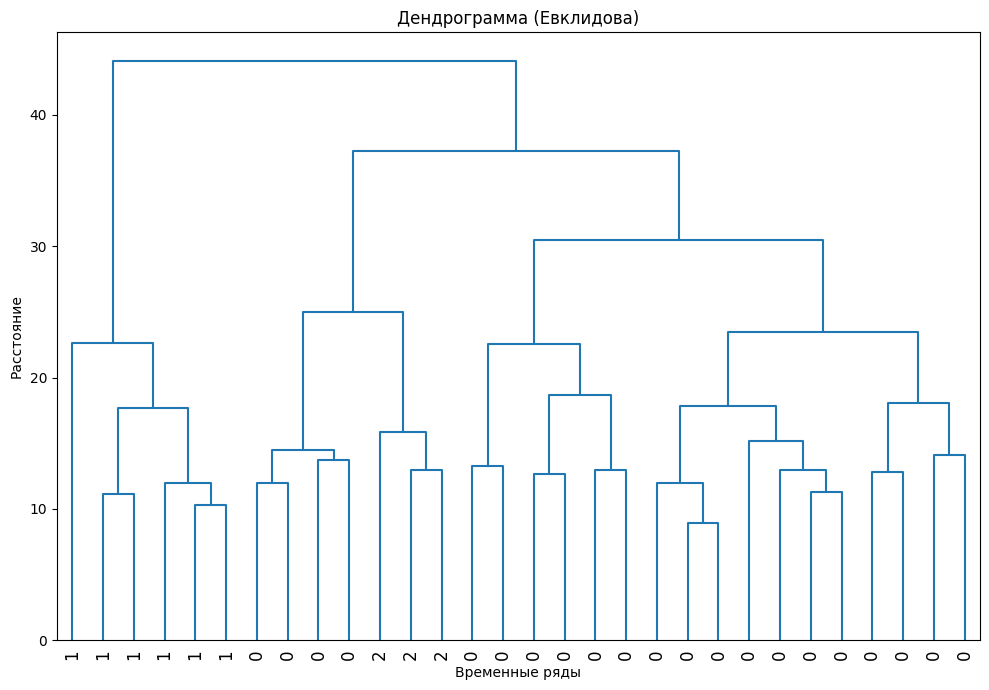

<ipython-input-17-5e4a81552c5b>:79: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



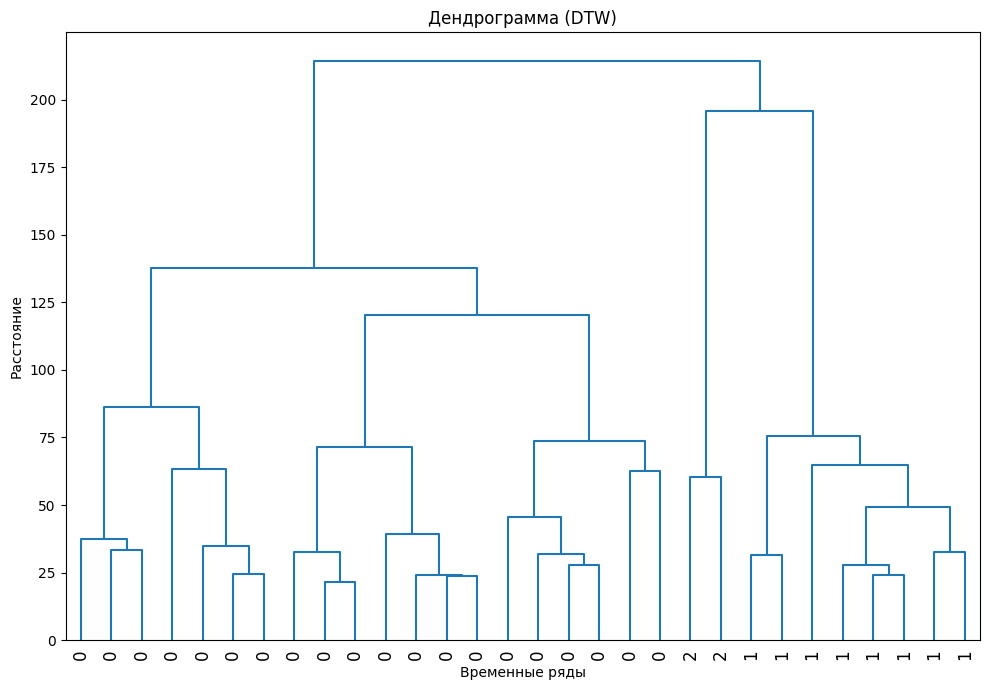

In [18]:
ts_set = data.iloc[:, 1:].values  # Замена .values на .to_numpy() может быть также подходящей.
labels = data.iloc[:, 0].values
# Вычисляем матрицы расстояний для евклидова и DTW расстояний
pairwise_distance_calculator_euclid = PairwiseDistance(metric='euclidean')
euclid_distance_matrix = pairwise_distance_calculator_euclid.calculate(ts_set)

pairwise_distance_calculator_dtw = PairwiseDistance(metric='dtw')
dtw_distance_matrix = pairwise_distance_calculator_dtw.calculate(ts_set)

# Создание экземпляра для иерархической кластеризации
model_euclid = TimeSeriesHierarchicalClustering(n_clusters=3)
model_euclid.fit(euclid_distance_matrix)
model_euclid.plot_dendrogram(data, model_euclid.labels_, ts_hspace=12, title="Дендрограмма (Евклидова)")

model_dtw = TimeSeriesHierarchicalClustering(n_clusters=3)
model_dtw.fit(dtw_distance_matrix)
model_dtw.plot_dendrogram(data, model_dtw.labels_, ts_hspace=12, title="Дендрограмма (DTW)")

Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [19]:
# INSERT YOUR CODE

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

In [21]:
# Вычисляем силуэтный коэффициент для евклидова расстояния
silhouette_score_euclid = silhouette_score(euclid_distance_matrix, model_euclid.labels_, metric='precomputed')
print(f"Силуэтный коэффициент (Евклидова расстояние): {silhouette_score_euclid:.4f}")

# Вычисляем силуэтный коэффициент для DTW расстояния
silhouette_score_dtw = silhouette_score(dtw_distance_matrix, model_dtw.labels_, metric='precomputed')
print(f"Силуэтный коэффициент (DTW расстояние): {silhouette_score_dtw:.4f}")

Силуэтный коэффициент (Евклидова расстояние): 0.1804
Силуэтный коэффициент (DTW расстояние): 0.3881


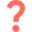
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

*# WRITE YOUR ANSWER*

Евклидова метрика продемонстрировала высокий силуэтный коэффициент в сравнении с DTW, что говорит о том, что объекты в задаче, скорее всего, расположены в пространстве, где классическая геометрия хорошо работает.

  Когда Предпочтительна Мера DTW:

*   Временные Ряды: DTW предпочтительнее, когда данные
представлены в виде временных рядов, так как она учитывает изменения в времени и позволяет сравнивать последовательности с различной длиной и искажениями по времени.
*   Сигналы и Модели Поведения: В обработки сигналов или анализе поведения, когда временные особенности критически важны для группировки.

*   Значительные Искажения: Если последовательности имеют вариации в скорости (например, одна последовательность может замедляться или ускоряться), DTW позволяет лучше справиться с этой сложностью.








## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [22]:
# INSERT YOUR CODE

In [23]:
def norm_ED_distance(ts1: np.ndarray, ts2: np.ndarray) -> float:
    """
    Calculate the normalized Euclidean distance

    Parameters
    ----------
    ts1: the first time series
    ts2: the second time series

    Returns
    -------
    norm_ed_dist: normalized Euclidean distance between ts1 and ts2s
    """

    n = len(ts1)

    # Вычисляем средние и стандартные отклонения
    mean_ts1 = np.mean(ts1)
    mean_ts2 = np.mean(ts2)

    std_ts1 = np.std(ts1)
    std_ts2 = np.std(ts2)

    # Вычисляем скалярное произведение временных рядов
    dot_product = np.dot(ts1, ts2)

    # Нормализованное расстояние
    norm_ed_dist = np.sqrt(2 * n * (1 - dot_product / (n * std_ts1 * std_ts2)))

    return norm_ed_dist

In [24]:
def z_normalize(ts: np.ndarray) -> np.ndarray:
    """
    Calculate the z-normalized time series by subtracting the mean and
    dividing by the standard deviation along a given axis

    Parameters
    ----------
    ts: time series

    Returns
    -------
    norm_ts: z-normalized time series
    """

    norm_ts = (ts - np.mean(ts, axis=0)) / np.std(ts, axis=0)

    return norm_ts

In [25]:
import numpy as np
from sktime.distances import euclidean_distance as sktime_normalized_euclidean_distance

# Генерируем случайные временные ряды
np.random.seed(0)
ts1 = np.random.rand(100)
ts2 = np.random.rand(100)

# Нормализуем временные ряды
norm_ts1 = z_normalize(ts1)
norm_ts2 = z_normalize(ts2)

# Вычисляем нормализованное евклидово расстояние
my_norm_distance = norm_ED_distance(norm_ts1, norm_ts2)

# Проверка с помощью sktime
expected_norm_distance = sktime_normalized_euclidean_distance(norm_ts1, norm_ts2)

# Сравниваем результаты
test_distances(my_norm_distance, expected_norm_distance)

print(f"My Normalized Euclidean Distance: {my_norm_distance}")
print(f"Sktime Normalized Euclidean Distance: {expected_norm_distance}")

My Normalized Euclidean Distance: 14.602103348818712
Sktime Normalized Euclidean Distance: 14.602103348818712


### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [44]:
url1 = '/content/drive/MyDrive/01 Basics/datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = '/content/drive/MyDrive/01 Basics/datasets/part2/chf11.csv'
ts2 = read_ts(url2)

In [45]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [46]:
plot_ts(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [47]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [48]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

In [31]:
# INSERT YOUR CODE

In [32]:
import numpy as np

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.utils import z_normalize


class PairwiseDistance:
    """
    Distance matrix between time series

    Parameters
    ----------
    metric: distance metric between two time series
            Options: {euclidean, dtw}
    is_normalize: normalize or not time series
    """

    def __init__(self, metric: str = 'euclidean', is_normalize: bool = False) -> None:

        self.metric: str = metric
        self.is_normalize: bool = is_normalize


    @property
    def distance_metric(self) -> str:
        """Return the distance metric

        Returns
        -------
            string with metric which is used to calculate distances between set of time series
        """

        norm_str = ""
        if (self.is_normalize):
            norm_str = "normalized "
        else:
            norm_str = "non-normalized "

        return norm_str + self.metric + " distance"


    def _choose_distance(self):
        """ Choose distance function for calculation of matrix

        Returns
        -------
        dict_func: function reference
        """

        if self.metric == 'euclidean':
            return norm_ED_distance if self.is_normalize else ED_distance
        elif self.metric == 'dtw':
            return DTW_distance
        else:
            raise ValueError("Unsupported metric: choose 'euclidean' or 'dtw'.")


    def calculate(self, input_data: np.ndarray) -> np.ndarray:
        """ Calculate distance matrix

        Parameters
        ----------
        input_data: time series set

        Returns
        -------
        matrix_values: distance matrix
        """

        matrix_shape = (input_data.shape[0], input_data.shape[0])
        matrix_values = np.zeros(shape=matrix_shape)



        ist_func = self._choose_distance()

        for i in range(input_data.shape[0]):
            for j in range(i + 1, input_data.shape[0]):
                if self.is_normalize:
                    # Применяем z-нормализацию к временным рядам перед вычислением расстояния
                    ts1 = z_normalize(input_data[i])
                    ts2 = z_normalize(input_data[j])
                else:
                    ts1 = input_data[i]
                    ts2 = input_data[j]

                dist = dist_func(ts1, ts2)
                matrix_values[i, j] = dist
                matrix_values[j, i] = dist  # матрица симметрична
        # INSERT YOUR CODE

        return matrix_values

In [42]:
import numpy as np
from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.utils import z_normalize

class PairwiseDistance:
    def __init__(self, metric: str = 'euclidean', is_normalize: bool = False) -> None:
        self.metric: str = metric
        self.is_normalize: bool = is_normalize

    @property
    def distance_metric(self) -> str:
        norm_str = "normalized " if self.is_normalize else "non-normalized "
        return norm_str + self.metric + " distance"

    def _choose_distance(self):
        if self.metric == 'euclidean':
            return norm_ED_distance if self.is_normalize else ED_distance
        elif self.metric == 'dtw':
            return DTW_distance
        else:
            raise ValueError("Unsupported metric: choose 'euclidean' or 'dtw'.")

    def calculate(self, input_data: np.ndarray) -> np.ndarray:
        matrix_shape = (input_data.shape[0], input_data.shape[0])
        matrix_values = np.zeros(shape=matrix_shape)
        dist_func = self._choose_distance()

        for i in range(input_data.shape[0]):
            for j in range(i + 1, input_data.shape[0]):
                if self.is_normalize:
                    # Применяем z-нормализацию к временным рядам перед вычислением расстояния
                    ts1 = z_normalize(input_data[i])
                    ts2 = z_normalize(input_data[j])
                else:
                    ts1 = input_data[i]
                    ts2 = input_data[j]

                dist = dist_func(ts1, ts2)
                matrix_values[i, j] = dist
                matrix_values[j, i] = dist  # матрица симметрична

        return matrix_values

In [49]:
class PairwiseDistance:
    def __init__(self, metric: str = 'euclidean', is_normalize: bool = False) -> None:
        self.metric: str = metric
        self.is_normalize: bool = is_normalize

    @property
    def distance_metric(self) -> str:
        norm_str = "normalized " if self.is_normalize else "non-normalized "
        return norm_str + self.metric + " distance"

    def _choose_distance(self):
        if self.metric == 'euclidean':
            return norm_ED_distance if self.is_normalize else ED_distance
        elif self.metric == 'dtw':
            return DTW_distance
        else:
            raise ValueError("Unsupported metric: choose 'euclidean' or 'dtw'.")

    def calculate(self, input_data: np.ndarray) -> np.ndarray:
        if self.is_normalize:
            input_data = np.array([z_normalize(ts) for ts in input_data])

        matrix_shape = (input_data.shape[0], input_data.shape[0])
        matrix_values = np.zeros(shape=matrix_shape)
        dist_func = self._choose_distance()

        for i in range(input_data.shape[0]):
            for j in range(i + 1, input_data.shape[0]):
                dist = dist_func(input_data[i], input_data[j])
                matrix_values[i, j] = dist
                matrix_values[j, i] = dist  # матрица симметрична

        return matrix_values

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

In [33]:
# INSERT YOUR CODE

<ipython-input-17-5e4a81552c5b>:79: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2818: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



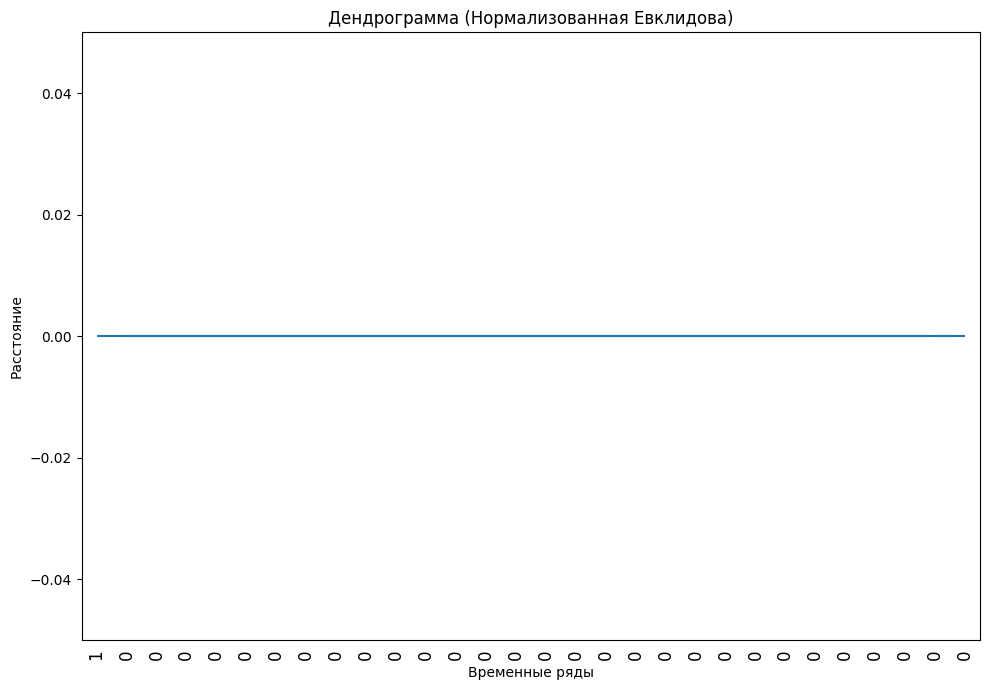

<ipython-input-17-5e4a81552c5b>:79: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2818: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



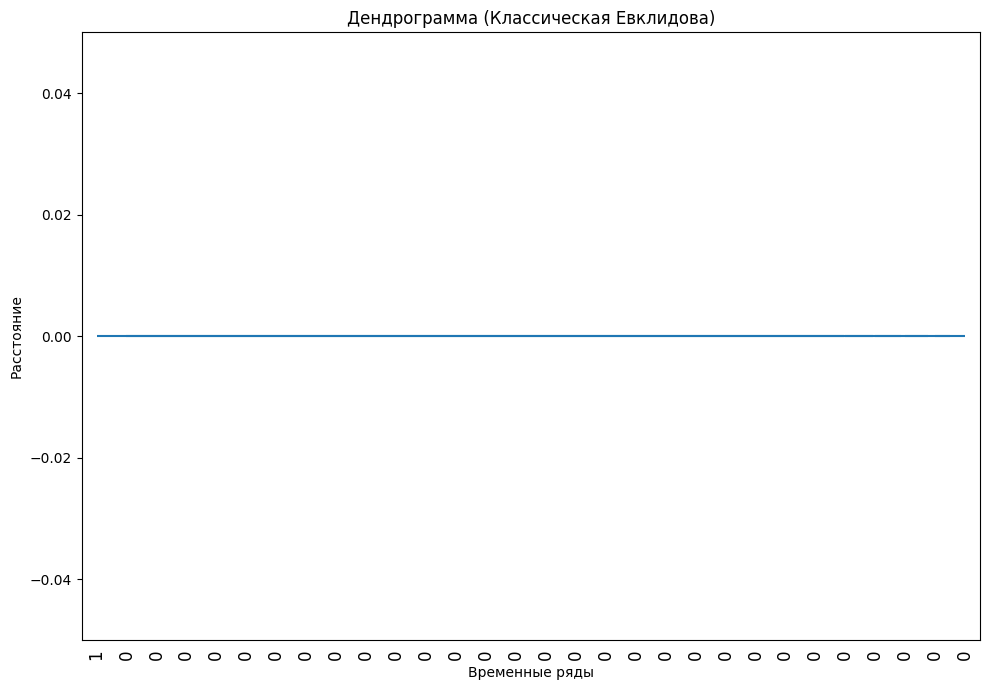

In [50]:
# Получение матрицы расстояний с нормализованной евклидовой метрикой
pairwise_distance_normalized = PairwiseDistance(metric='euclidean', is_normalize=True)
normalized_distance_matrix = pairwise_distance_normalized.calculate(subs_set)

# Иерархическая кластеризация с использованием дистанционной матрицы
model_normalized = TimeSeriesHierarchicalClustering(n_clusters=2)
model_normalized.fit(normalized_distance_matrix)
model_normalized.plot_dendrogram(subs_set, model_normalized.labels_, ts_hspace=12, title="Дендрограмма (Нормализованная Евклидова)")

# Вычисление расстояний с использованием классической евклидовой метрики
pairwise_distance_classic = PairwiseDistance(metric='euclidean', is_normalize=False)
classic_distance_matrix = pairwise_distance_classic.calculate(subs_set)

# Иерархическая кластеризация с использованием дистанционной матрицы
model_classic = TimeSeriesHierarchicalClustering(n_clusters=2)
model_classic.fit(classic_distance_matrix)
model_classic.plot_dendrogram(subs_set, model_classic.labels_, ts_hspace=12, title="Дендрограмма (Классическая Евклидова)")

In [51]:
# Загрузка временных рядов
url1 = '/content/drive/MyDrive/01 Basics/datasets/part2/chf10.csv'
ts1 = read_ts(url1)
url2 = '/content/drive/MyDrive/01 Basics/datasets/part2/chf11.csv'
ts2 = read_ts(url2)
ts_set = np.concatenate((ts1, ts2), axis=1).T

# Слайдинг для подпоследовательностей
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

# Кластеризация без нормализации
pairwise_distance_calculator = PairwiseDistance(metric='euclidean', is_normalize=False)
euclid_distance_matrix = pairwise_distance_calculator.calculate(subs_set)
model_euclid = TimeSeriesHierarchicalClustering(n_clusters=2)
model_euclid.fit(euclid_distance_matrix)

# Кластеризация с нормализацией
pairwise_distance_calculator_normalized = PairwiseDistance(metric='euclidean', is_normalize=True)
norm_euclid_distance_matrix = pairwise_distance_calculator_normalized.calculate(subs_set)
model_normalized_euclid = TimeSeriesHierarchicalClustering(n_clusters=2)
model_normalized_euclid.fit(norm_euclid_distance_matrix)

# Вычисление силуэтных коэффициентов
silhouette_score_euclid = silhouette_score(euclid_distance_matrix, model_euclid.labels_, metric='precomputed')
silhouette_score_normalized_euclid = silhouette_score(norm_euclid_distance_matrix, model_normalized_euclid.labels_, metric='precomputed')

print(f"Силуэтный коэффициент без нормализации: {silhouette_score_euclid:.4f}")
print(f"Силуэтный коэффициент с нормализацией: {silhouette_score_normalized_euclid:.4f}")

Силуэтный коэффициент без нормализации: 0.0000
Силуэтный коэффициент с нормализацией: 0.0000


<ipython-input-17-5e4a81552c5b>:79: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

<ipython-input-17-5e4a81552c5b>:79: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



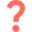
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

*# WRITE YOUR ANSWER*

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}

\
<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

In [ ]:
# INSERT YOUR CODE

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


In [ ]:
angle_step = 20
visualize = True

ts = image2ts(img, angle_step, visualize)
plot_ts(np.array([ts]), "Time series representation of image")

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [ ]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [ ]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

In [ ]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [ ]:
# INSERT YOUR CODE

Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [ ]:
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# INSERT YOUR CODE

In [ ]:
metric = 'dtw'
metric_params = {'normalize': True}

# INSERT YOUR CODE

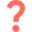
Проанализируйте результаты и сделайте выводы.

*# WRITE YOUR ANSWER*